
#### 1.1 How many goals were attempted by head
#### 1.2 How many matches had attendees more than 12000
#### 2.1 Shots list where goal was scored outside 16m box sorted by descending order
#### 2.2 Rank teams based on average attendance at home games 

Database dropped


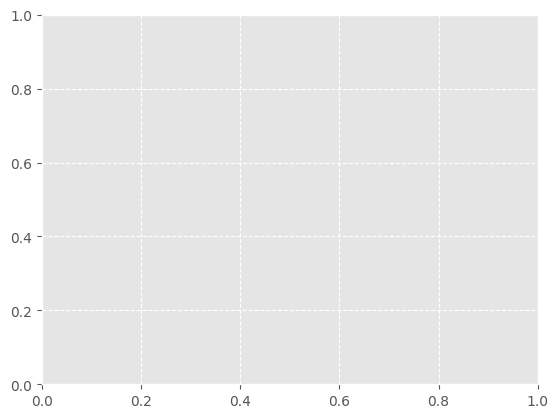

In [1]:
%matplotlib inline
from MongoStruct import *  
from ERDGraph import *

### Load all preprocessed data, dataframes and collections and show the Execution Time

In [2]:
@measure_execution_time
def MongoExecTime():
    return get_all_data()

print('----Loading Mongo----')
result, execution_time = MongoExecTime()  # Get both the result and execution time

# Unpack the 9 values from the result
client, shots_collection, matches_collection, players_collection, teams_collection, df_shots, df_matches, df_players, df_teams = result
aggregated_collection = db['aggregated_results']


----Loading Mongo----
shots Collection dropped
matches Collection dropped
players Collection dropped
teams Collection dropped
# shots documents: 245180
# matches documents: 14148
# players documents: 20414
# teams documents: 675
Execution time: 18.3248 seconds


In [3]:
# print(df_shots.columns)
# print(df_shots.head(5))
# print(df_matches.columns)
# print(df_matches.head(5))
# print(df_players.columns)
# print(df_players.head(5))
# print(df_teams.columns)
# print(df_teams.head(5))

Index(['Player', 'Outcome', 'Distance', 'Body Part', 'match_id'], dtype='object')
     Player     Outcome  Distance   Body Part  match_id
0  4a1a9578        Goal       8.0        Head  de515487
1  b9e1436c        Goal      22.0   Left Foot  de515487
2  01ce9e70       Saved       8.0        Head  de515487
3  e342ad68  Off Target       2.0   Left Foot  de515487
4  e4238fb1       Saved      30.0  Right Foot  de515487
Index(['Date', 'league', 'Round', 'Day', 'Attendance', 'home_id', 'away_id',
       'score_away', 'score_home'],
      dtype='object')
         Date  league  Round  Day  Attendance   home_id   away_id  score_away  \
0  2021-04-12      20     20  Mon           0  033ea6b8  c7a9f859           0   
1  2022-10-09      11     11  Sun       24671  04eea015  922493f3           2   
2  2018-10-25      19     19  Thu       38126  acbb6a5b  b81aa4fa           0   
3  2023-12-03      12     12  Sun       34568  206d90db  db3b9613           0   
4  2023-11-04      13     13  Sat       16

#### 1.1 How many goals were attempted by head

In [4]:
# Define your query
query = {"Outcome": "Goal", "Body Part": "Head"}

# Create compound index beforehand if needed
def create_compound_index_1_1():
    # Create index once (if not already created)
    shots_collection.create_index([("Outcome", 1), ("Body Part", 1)], name='compound_index')

# Function to execute query with or without index
@measure_execution_time
def MongoQ1_1(index=False):
    # Create index only once outside of the query function
    if index:
        create_compound_index_1_1()
        print("Explain output --With-- index:")
    else:
        print("Explain output --Without-- index:")
    
    # Execute the query
    result = shots_collection.find(query, {"Outcome": 1, "Body Part": 1})  # Using projection to limit fields

    # Explain query execution plan
    result_index = result.explain()
    pprint.pprint(result_index["executionStats"])
    print('Query 1.1')
    
    # Return result to see output if needed
    return result

# Execute the function and measure execution time with and without index
result, execution_time = MongoQ1_1(index=False)
result_index, execution_time_index = MongoQ1_1(index=True)

# Compare execution times
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Explain output --Without-- index:
{'allPlansExecution': [],
 'executionStages': {'advanced': 3963,
                     'executionTimeMillisEstimate': 132,
                     'inputStage': {'advanced': 3963,
                                    'direction': 'forward',
                                    'docsExamined': 245180,
                                    'executionTimeMillisEstimate': 132,
                                    'filter': {'$and': [{'Body Part': {'$eq': 'Head'}},
                                                        {'Outcome': {'$eq': 'Goal'}}]},
                                    'isEOF': 1,
                                    'nReturned': 3963,
                                    'needTime': 241217,
                                    'needYield': 0,
                                    'restoreState': 7,
                                    'saveState': 7,
                                    'stage': 'COLLSCAN',
                                    'works': 24

#### 1.2 How many matches had attendees more than 12000

In [5]:
# Define the query
query = {"Attendance": {"$gt": 12000}}

# Create index once before running queries
def create_compound_index_1_2():
    # Create index on Attendance field
    matches_collection.create_index([("Attendance", 1)], name='attendance_index')

# Function to execute query with or without index
@measure_execution_time
def MongoQ1_2(index=False):
    # Create index only once outside of the query function
    if index:
        create_compound_index_1_2()
        print("Explain output --With-- index:")
    else:
        print("Explain output --Without-- index:")
    
    # Execute the query
    result = matches_collection.find(query)  # You can add a projection if needed
    
    # Get query execution stats using correct explain() method
    result_index = result.explain() 
    # Correct usage of explain
    
    # Print the execution statistics
    pprint.pprint(result_index["executionStats"])
    
    # Return result (if you need to use or display it)
    return result

# Execute the function and measure execution time with and without index
result, execution_time = MongoQ1_2(index=False)
result_index, execution_time_index = MongoQ1_2(index=True)

# Compare execution times
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Explain output --Without-- index:
{'allPlansExecution': [],
 'executionStages': {'advanced': 9166,
                     'direction': 'forward',
                     'docsExamined': 14148,
                     'executionTimeMillisEstimate': 0,
                     'filter': {'Attendance': {'$gt': 12000}},
                     'isCached': False,
                     'isEOF': 1,
                     'nReturned': 9166,
                     'needTime': 4982,
                     'needYield': 0,
                     'restoreState': 0,
                     'saveState': 0,
                     'stage': 'COLLSCAN',
                     'works': 14149},
 'executionSuccess': True,
 'executionTimeMillis': 8,
 'nReturned': 9166,
 'totalDocsExamined': 14148,
 'totalKeysExamined': 0}
Execution time: 0.0100 seconds
Explain output --With-- index:
{'allPlansExecution': [],
 'executionStages': {'advanced': 9166,
                     'alreadyHasObj': 0,
                     'docsExamined': 9166,
         

#### 2.1 Testing Index combinations

In [6]:
# Function to check if an index exists for the given keys
def index_exists(index_fields):
    existing_indexes = shots_collection.list_indexes()
    for index in existing_indexes:
        if set(index['key'].keys()) == set(index_fields):
            return True
    return False

# Function to create compound indexes based on query keys
def create_compound_index(query_keys):
    index_name = f"compound_index_{'_'.join(query_keys)}"
    if not index_exists(query_keys):  # Only create the index if it doesn't already exist
        shots_collection.create_index([(key, 1) for key in query_keys], name=index_name)
        # print(f"Created compound index for query: {query_keys}")
    # else:
    #     print(f"Compound index for query: {query_keys} already exists, skipping index creation.")
    return index_name  # Return the index name so we can drop it later

# Function to drop an index after it is used
def drop_index(index_name):
    try:
        shots_collection.drop_index(index_name)
    #     print(f"Dropped index: {index_name}")
    except Exception as e:
        print(f"Error dropping index {index_name}: {str(e)}")

# Function to execute aggregation pipeline with or without index
@measure_execution_time
def MongoQ2_1(query, index=False):
    # If index is enabled, create the relevant compound index
    index_name = None
    if index:
        index_name = create_compound_index(list(query.keys()))  # Use query keys to create the compound index
        # print(f"Explain output --With-- index for query: {query}")
    
    # Define the aggregation pipeline with $lookup to join player data
    pipeline = [
        {
            '$match': query  # Match the current query fields
        },
        {
            '$group': {
                '_id': '$Player',  # Group by Player
                'gt_16': {
                    '$sum': {
                        '$cond': [{'$gt': ['$Distance', 16]}, 1, 0]  # Count distances > 16
                    }
                },
                'total_goals': {'$sum': 1}  # Count the total goals for each player
            }
        },
        {
            '$addFields': {
                'lt_16': {'$subtract': ['$total_goals', '$gt_16']}  # Compute distances <= 16
            }
        },
        {
            '$lookup': {
                'from': 'players',        # Join with 'players' collection
                'localField': '_id',      # Use 'Player' field in the current collection
                'foreignField': 'id',     # Match it with 'id' field in 'players'
                'as': 'player_info'       # Output array field
            }
        },
        {
            '$unwind': {
                'path': '$player_info',
                'preserveNullAndEmptyArrays': False  # Ignore unmatched players
            }
        },
        {
            '$group': {  # Regroup after $lookup to ensure one document per player
                '_id': '$_id',
                'Name': {'$first': '$player_info.name'},  # Take the first matched name
                'total_goals': {'$first': '$total_goals'},
                'gt_16': {'$first': '$gt_16'},
                'lt_16': {'$first': '$lt_16'}
            }
        },
        {
            '$project': {
                '_id': 0,  # Exclude the _id field
                'Name': 1,
                'total_goals': 1,
                'gt_16': 1,
                'lt_16': 1
            }
        },
        {
            '$sort': {'total_goals': -1}  # Sort by total_goals in descending order
        }
    ]

    # Run aggregation pipeline on shots_collection
    result = list(shots_collection.aggregate(pipeline))

    # Handle the missing 'Name' field by extracting it from the 'player_info' array
    for player in result:
        if 'player_info' in player and player['player_info']:
            player['Name'] = player['player_info'][0].get('name', None)
        else:
            player['Name'] = None

    # Drop the index if it was created
    if index_name:
        drop_index(index_name)

    return result

# Function to run all combinations of queries with and without indexes
def run_all_combinations():
    query = {"Outcome": "Goal", "Player": "PlayerID", "Distance": 16}  # Corrected Distance value to 16
    combinations = get_dict_combinations(query)  # Get all combinations of the query fields
    
    # Initialize a list to store speedup comparisons for indexed queries
    speedup_comparisons = []

    for combo in combinations:
        # print(f"\nRunning query combination with index: {combo}")
        
        # Run the aggregation pipeline with index
        result, execution_time_with_index = MongoQ2_1(combo, index=True)

        # Print the execution time and results for the indexed query
        # print(f"Execution time with index: {execution_time_with_index:.4f} seconds")

        # Explain the query execution plan
        explain_output = shots_collection.find(combo).explain()
        # print("Explain Output -- With Index:")
        # pprint.pprint(explain_output["executionStats"])


        # Only compare execution times for indexed queries
        speedup_comparisons.append((combo, execution_time_with_index))

    # Optional: Print the speedup comparisons (execution time for indexed queries)
    print("\nSpeedup Comparisons (only with index):")
    for combo, exec_time in speedup_comparisons:
        print(f"Query: {combo} | Execution Time (With Index): {exec_time:.4f} seconds")

# Execute the main function to run queries
run_all_combinations()


Execution time: 35.4424 seconds
Execution time: 0.6003 seconds
Execution time: 31.3678 seconds
Execution time: 0.6160 seconds
Execution time: 7.8821 seconds
Execution time: 0.6153 seconds
Execution time: 0.6585 seconds

Speedup Comparisons (only with index):
Query: {'Outcome': 'Goal'} | Execution Time (With Index): 35.4424 seconds
Query: {'Player': 'PlayerID'} | Execution Time (With Index): 0.6003 seconds
Query: {'Distance': 16} | Execution Time (With Index): 31.3678 seconds
Query: {'Outcome': 'Goal', 'Player': 'PlayerID'} | Execution Time (With Index): 0.6160 seconds
Query: {'Outcome': 'Goal', 'Distance': 16} | Execution Time (With Index): 7.8821 seconds
Query: {'Player': 'PlayerID', 'Distance': 16} | Execution Time (With Index): 0.6153 seconds
Query: {'Outcome': 'Goal', 'Player': 'PlayerID', 'Distance': 16} | Execution Time (With Index): 0.6585 seconds


#### 2.1 Total Goals Scoared and Inside VS Outside 16m box with fastest index combination

In [7]:
@measure_execution_time
def MongoQ2_1(index=False):
    # Define the aggregation pipeline with $lookup to join player data
    pipeline = [
        {
            '$match': {
                'Outcome': 'Goal'  # Filter for documents where Outcome is 'Goal'
            }
        },
        {
            '$group': {
                '_id': '$Player',  # Group by Player
                'gt_16': {
                    '$sum': {
                        '$cond': [{'$gt': ['$Distance', 16]}, 1, 0]  # Count distances > 16
                    }
                },
                'total_goals': {'$sum': 1}  # Count the total goals for each player
            }
        },
        {
            '$addFields': {
                'lt_16': {'$subtract': ['$total_goals', '$gt_16']}  # Compute distances <= 16
            }
        },
        {
            '$lookup': {
                'from': 'players',        # Join with 'players' collection
                'localField': '_id',      # Use 'Player' field in the current collection
                'foreignField': 'id',     # Match it with 'id' field in 'players'
                'as': 'player_info'       # Output array field
            }
        },
        {
            '$unwind': {
                'path': '$player_info',
                'preserveNullAndEmptyArrays': False  # Ignore unmatched players
            }
        },
        {
            '$group': {  # Regroup after $lookup to ensure one document per player
                '_id': '$_id',
                'Name': {'$first': '$player_info.name'},  # Take the first matched name
                'total_goals': {'$first': '$total_goals'},
                'gt_16': {'$first': '$gt_16'},
                'lt_16': {'$first': '$lt_16'}
            }
        },
        {
            '$project': {
                '_id': 0,  # Exclude the _id field
                'Name': 1,
                'total_goals': 1,
                'gt_16': 1,
                'lt_16': 1
            }
        },
        {
            '$sort': {'total_goals': -1}  # Sort by total_goals in descending order
        }
    ]

    # If index is enabled, create relevant indexes for optimization (Player, Distance)
    if index:
        shots_collection.create_index([("Player", 1), ("Distance", 1)], name="player_distance_index")
        print("Explain output -- With-- index:")

    # Run the aggregation pipeline on shots_collection
    result = shots_collection.aggregate(pipeline)
    
    # Use Database.command() to get the explain stats of the aggregation pipeline
    explain_output = shots_collection.database.command("aggregate", "shots", pipeline=pipeline, explain=True)

    # Print the entire explain output to inspect the structure
    print("Full Explain Output:")
    pprint.pprint(explain_output)

    # Now, check if executionStats is present
    if "executionStats" in explain_output:
        pprint.pprint(explain_output["executionStats"])
    else:
        print("executionStats not found in explain output.")

    # Convert the aggregation result to a list
    result = list(result)

    return result

# Execute the function and measure execution time with or without index
result, execution_time = MongoQ2_1(index=False)
result_index, execution_time_index = MongoQ2_1(index=True)

# Dataframe for easy manipulation and visualization
df = pd.DataFrame(result)

# Return the final merged result as a pandas DataFrame
print("\nFinal Merged Results:")
df = df[['Name', 'total_goals', 'gt_16', 'lt_16']]  # Select relevant columns
print(df.head(10))  # Show top 10 results

# Compare execution times with and without the index
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')

# Insert results into the 'aggregated_results' collection if data exists
if result:
    aggregated_collection.insert_many(result_index)  # Insert all aggregated documents
    print(f"Inserted {len(result)} records into 'aggregated_results' collection.")


Full Explain Output:
{'command': {'$db': 'DB_football',
             'aggregate': 'shots',
             'explain': True,
             'lsid': {'id': Binary(b',w\xb3\x93\xa0\xcdG~\xb1D\xfb\x88\xc9\x99Na', 4)},
             'pipeline': [{'$match': {'Outcome': 'Goal'}},
                          {'$group': {'_id': '$Player',
                                      'gt_16': {'$sum': {'$cond': [{'$gt': ['$Distance',
                                                                            16]},
                                                                   1,
                                                                   0]}},
                                      'total_goals': {'$sum': 1}}},
                          {'$addFields': {'lt_16': {'$subtract': ['$total_goals',
                                                                  '$gt_16']}}},
                          {'$lookup': {'as': 'player_info',
                                       'foreignField': 'id',
           

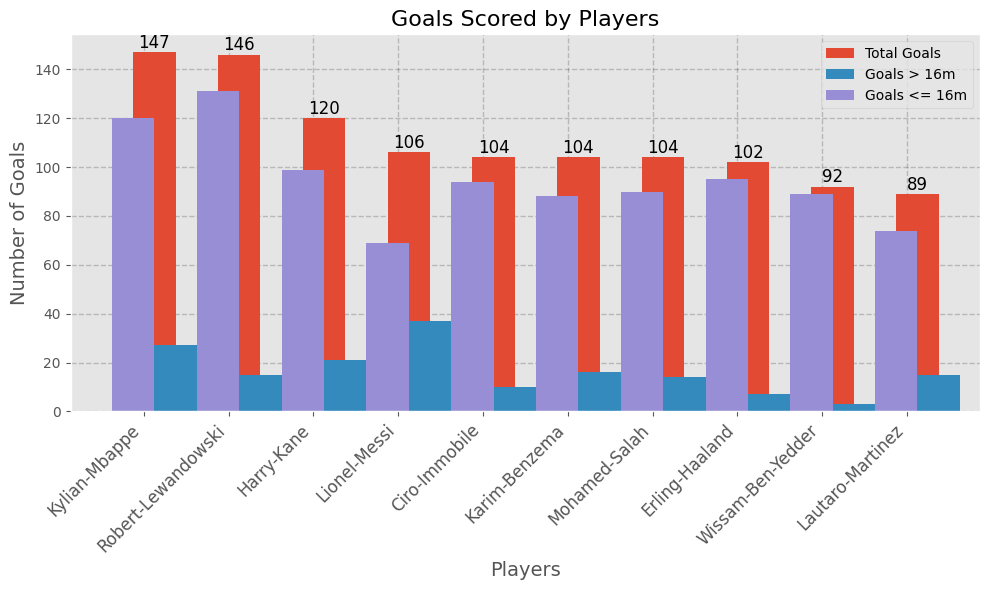

In [8]:
plot_goals_bar_chart(df.head(10))

#### 2.2 Rank teams based on average attendance at home games

In [9]:
# Function to execute query with aggregation pipeline and team lookup
@measure_execution_time
def MongoQ2_2(index=False):
    # Define aggregation pipeline with additional stages
    pipeline_1 = [
        {
            '$group': {
                '_id': '$home_id',
                'average_attendance': {'$avg': '$Attendance'},
                'matches_count': {'$sum': 1}
            }
        },
        {
            '$lookup': {
                'from': 'teams', 
                'localField': '_id', 
                'foreignField': 'id', 
                'as': 'team_info'
            }
        },
        {
            '$unwind': '$team_info'
        },
        {
            '$project': {
                '_id': 0,
                'home_id': '$_id',
                'average_attendance': 1,
                'matches_count': 1,
                'team_name': '$team_info.name'
            }
        },
        {
            '$sort': {'average_attendance': -1}
        }
    ]

    # If index is enabled, create relevant indexes for optimization (home_id, Attendance)
    if index:
        matches_collection.create_index([("home_id", 1), ("Attendance", 1)], name="home_attendance_index")
        print("Explain output --With-- index:")

    # Run aggregation pipeline on matches_collection
    result = list(matches_collection.aggregate(pipeline_1))


    return result

# Execute the function and measure execution time with or without index
result, execution_time = MongoQ2_2(index=False)
result_index, execution_time_index = MongoQ2_2(index=True)

# Dataframe for easy manipulation and visualization
df = pd.DataFrame(list(result))
# Return the final merged result as a pandas DataFrame
print("\nFinal Merged Results:")
df = df[['team_name', 'average_attendance', 'matches_count']]  # Select relevant columns
print(df.head(10))  # Show top 10 results

# Compare execution times with and without the index
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Execution time: 0.2791 seconds
Explain output --With-- index:
Execution time: 0.3297 seconds

Final Merged Results:
           team_name  average_attendance  matches_count
0  Manchester United        56407.227273            176
1           Dortmund        56036.021583            139
2            Benfica        54471.142857             14
3       Hamburger SV        52331.000000              3
4          Barcelona        51691.458599            157
5      Bayern Munich        50702.652482            141
6        Real Madrid        47265.540373            161
7    West Ham United        46952.068966            145
8            Arsenal        46577.050000            160
9     Internazionale        46508.773585            159
--Execution is: 0.8463163618116903 Times Faster with Index--


#### Print all aggregated_results

In [10]:
# Verify data insertion
aggregated_results = db['aggregated_results']
print("Inserted Data:")
for doc in aggregated_results.find().limit(10):  # Show the first 10 documents in the collection
    print(doc)


Inserted Data:
{'_id': ObjectId('675f5952577fd97a7f95ca0f'), 'Name': 'Kylian-Mbappe', 'total_goals': 147, 'gt_16': 27, 'lt_16': 120}
{'_id': ObjectId('675f5952577fd97a7f95ca10'), 'Name': 'Robert-Lewandowski', 'total_goals': 146, 'gt_16': 15, 'lt_16': 131}
{'_id': ObjectId('675f5952577fd97a7f95ca11'), 'Name': 'Harry-Kane', 'total_goals': 120, 'gt_16': 21, 'lt_16': 99}
{'_id': ObjectId('675f5952577fd97a7f95ca12'), 'Name': 'Lionel-Messi', 'total_goals': 106, 'gt_16': 37, 'lt_16': 69}
{'_id': ObjectId('675f5952577fd97a7f95ca13'), 'Name': 'Ciro-Immobile', 'total_goals': 104, 'gt_16': 10, 'lt_16': 94}
{'_id': ObjectId('675f5952577fd97a7f95ca14'), 'Name': 'Karim-Benzema', 'total_goals': 104, 'gt_16': 16, 'lt_16': 88}
{'_id': ObjectId('675f5952577fd97a7f95ca15'), 'Name': 'Mohamed-Salah', 'total_goals': 104, 'gt_16': 14, 'lt_16': 90}
{'_id': ObjectId('675f5952577fd97a7f95ca16'), 'Name': 'Erling-Haaland', 'total_goals': 102, 'gt_16': 7, 'lt_16': 95}
{'_id': ObjectId('675f5952577fd97a7f95ca17'), 

### 4C CREATE TABLES statements

In [11]:
for i in Mongo_table_statements():
    print(i)

MongoDB Collection: shots Schema
    Player: string
    Outcome: string
    Distance: double
    Body Part: string
    match_id: string
MongoDB Collection: matches Schema
    Date: string
    league: int
    Round: int
    Day: string
    Attendance: int
    home_id: string
    away_id: string
    score_away: int
    score_home: int
MongoDB Collection: all_players Schema
    id: string
    Pos: string
    Matches: string
    club_id: string
    MP: double
    year: string
    name: string
MongoDB Collection: teams Schema
    id: string
    name: string
    league: int
    W: double
    D: double
    L: double
    MP: double
    GF: double
    GA: double
    GD: double
    Pts: double


In [13]:
# Close the connection after operations are complete
client.close()